In [ ]:

!pip install qiskit
!pip install pylatexenc
#!pip install --upgrade qiskit
#!pip install qiskit-aer
#!pip install qiskit-ibmq-provider



#from qiskit import IBMQ , Aer, execute
#from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider

In [ ]:
pip install qiskit-aer


Measurement Results: {'111': 1, '110': 2, '101': 2, '100': 173, '000': 4, '010': 158, '001': 172}


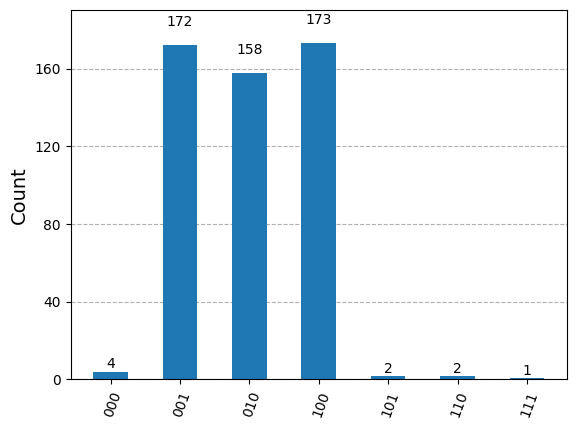

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import qiskit_aer.noise as noise
import numpy as np

# Create registers with three quantum bits and three classical bits
qr = QuantumRegister(3, name="qr")
cr = ClassicalRegister(3, name="cr")

# Define a F_gate
def F_gate(circ, q, i, j, n, k):
    theta = np.arccos(np.sqrt(1 / (n - k + 1)))
    circ.ry(-theta, q[j])
    circ.cz(q[i], q[j])
    circ.ry(theta, q[j])
    circ.barrier(q[i])

# Define the cxrv gate which uses reverse CNOT instead of CNOT
def cxrv(circ, q, i, j):
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j], q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i], q[j])

# Define the flag_qx2 variable
flag_qx2 = True  # Set it to True or False based on your requirements

# Create W-state circuit
singlet = QuantumCircuit(qr, cr)
singlet.x(qr[2])  # Start in |100>
F_gate(singlet, qr, 2, 1, 3, 1)  # Applying F12
F_gate(singlet, qr, 1, 0, 3, 2)  # Applying F23

if flag_qx2:  # Option ibmqx2
    singlet.cx(qr[1], qr[2])  # cNOT 21
    singlet.cx(qr[0], qr[1])  # cNOT 32
else:  # Option ibmqx4
    cxrv(singlet, qr, 1, 2)
    cxrv(singlet, qr, 0, 1)

# Ensure measurements are included
singlet.measure(qr, cr)  # Measure all qubits

# Set up the noise model (if required)
prob_1 = 0.001  # 1-qubit gate error probability
prob_2 = 0.01   # 2-qubit gate error probability

# Create a noise model
error_1 = noise.depolarizing_error(prob_1, 1)  # 1-qubit depolarizing error
error_2 = noise.depolarizing_error(prob_2, 2)  # 2-qubit depolarizing error

# Initialize the noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])  # Apply to two-qubit CNOT gates

# Set up the Aer simulator with the noise model
backend = AerSimulator(noise_model=noise_model)

# Transpile the circuit for the backend
transpiled_circuit = transpile(singlet, backend)

# Run the simulation
result = backend.run(transpiled_circuit, shots=512).result()

# Get results and print counts
counts = result.get_counts()  # Remove the circuit parameter
print("Measurement Results:", counts)

# Optional: Visualize the results
plot_histogram(counts)


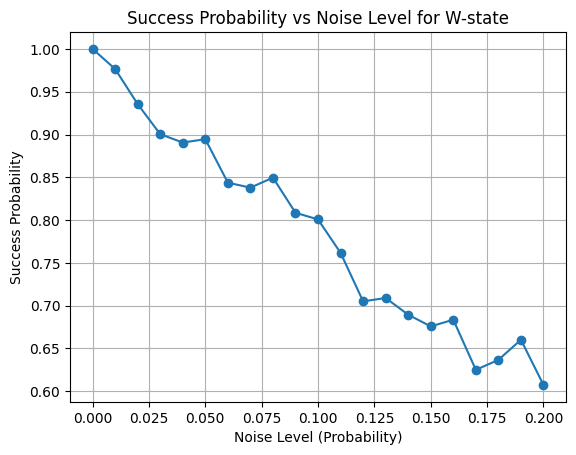

In [ ]:
import matplotlib.pyplot as plt


# Function to calculate success probability
def is_successful(result):
    counts = result.get_counts()
    successful_outcomes = ['001', '010', '100']  # Desired outcomes
    success_count = sum(counts.get(outcome, 0) for outcome in successful_outcomes)  # Count successful outcomes
    total_count = sum(counts.values())  # Total counts

    # Check for success and return the probability
    return success_count / total_count if total_count > 0 else 0

# Run simulations for different noise levels
def run_simulations(noise_levels, shots=512):
    success_probabilities = []

    for noise_prob in noise_levels:
        # Create a noise model
        error_1 = noise.depolarizing_error(noise_prob, 1)  # 1-qubit depolarizing error
        error_2 = noise.depolarizing_error(noise_prob, 2)  # 2-qubit depolarizing error

        noise_model = noise.NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])  # Apply to two-qubit CNOT gates

        # Set up the Aer simulator with the noise model
        backend = AerSimulator(noise_model=noise_model)

        # Transpile the circuit for the backend
        transpiled_circuit = transpile(singlet, backend)

        # Run the simulation
        result = backend.run(transpiled_circuit, shots=shots).result()

        # Calculate success probability
        success_probability = is_successful(result)
        success_probabilities.append(success_probability)

    return success_probabilities

# Define noise levels from 0% to 10%
noise_levels = [i / 100 for i in range(0, 21)]  # Adjust this range as needed
success_probabilities = run_simulations(noise_levels)

# Plot the results
plt.plot(noise_levels, success_probabilities, marker='o')
plt.xlabel('Noise Level (Probability)')
plt.ylabel('Success Probability')
plt.title('Success Probability vs Noise Level for W-state')
plt.grid()
plt.show()


In [ ]:
# Function to run simulations for a specific noise type
def run_simulation_for_noise_type(noise_type, noise_levels, circuit, shots=512):
    success_probabilities = []

    for noise_prob in noise_levels:
        noise_model = noise.NoiseModel()  # Initialize the noise model

        # Create a noise model based on the specified noise type
        if noise_type == 'bit-flip':
            # Bit-flip error (1-qubit gate)
            error = noise.depolarizing_error(noise_prob, 1)  # 1-qubit depolarizing error
            noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates

        elif noise_type == 'phase-flip':
            # Phase-flip error (1-qubit gate)
            error = noise.depolarizing_error(noise_prob, 1)  # 1-qubit depolarizing error
            noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates

        elif noise_type == 'depolarizing':
            # Depolarizing error (1-qubit depolarizing error)
            error = noise.depolarizing_error(noise_prob, 1)  # 1-qubit depolarizing error
            noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates
            noise_model.add_all_qubit_quantum_error(error, ['cx'])  # Apply to two-qubit CNOT gates

        else:
            raise ValueError("Unknown noise type: {}".format(noise_type))

        # Set up the Aer simulator with the noise model
        backend = AerSimulator(noise_model=noise_model)

        # Transpile the circuit for the backend
        transpiled_circuit = transpile(circuit, backend)

        # Run the simulation
        result = backend.run(transpiled_circuit, shots=shots).result()

        # Calculate success probability
        success_probability = is_successful(result)
        success_probabilities.append(success_probability)

    return success_probabilities


In [ ]:
# Function to run simulations for a specific noise type
def run_simulation_for_noise_type(noise_type, noise_levels, circuit, shots=512):
    success_probabilities = []

    for noise_prob in noise_levels:
        noise_model = noise.NoiseModel()  # Initialize the noise model

        # Create a noise model based on the specified noise type
        if noise_type == 'bit-flip':
            # Create bit-flip error (1-qubit depolarizing error)
            error = noise.depolarizing_error(noise_prob, 1)
            noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates

        elif noise_type == 'phase-flip':
            # Create phase-flip error (1-qubit depolarizing error)
            error = noise.depolarizing_error(noise_prob, 1)
            noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates

        elif noise_type == 'depolarizing':
            # Create a depolarizing error (1-qubit depolarizing error)
            error = noise.depolarizing_error(noise_prob, 1)
            noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])  # Apply to single-qubit gates

            # Create a separate depolarizing error for CNOT gate (2-qubit gate)
            error_cx = noise.depolarizing_error(noise_prob, 2)
            noise_model.add_all_qubit_quantum_error(error_cx, ['cx'])  # Apply to two-qubit CNOT gates

        else:
            raise ValueError("Unknown noise type: {}".format(noise_type))

        # Set up the Aer simulator with the noise model
        backend = AerSimulator(noise_model=noise_model)

        # Transpile the circuit for the backend
        transpiled_circuit = transpile(circuit, backend)

        # Run the simulation
        result = backend.run(transpiled_circuit, shots=shots).result()

        # Calculate success probability
        success_probability = is_successful(result)
        success_probabilities.append(success_probability)

    return success_probabilities


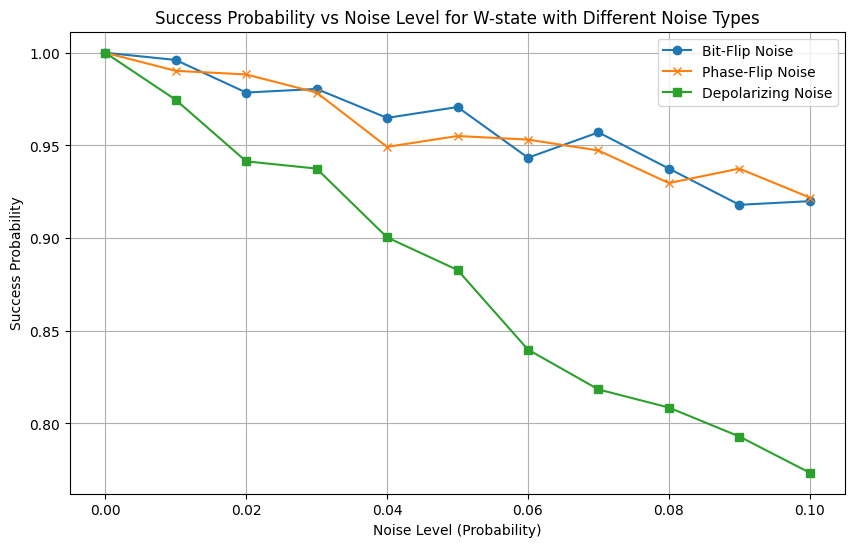

In [ ]:
# Run simulations for each type of noise
bit_flip_results = run_simulation_for_noise_type('bit-flip', noise_levels, transpiled_circuit)
phase_flip_results = run_simulation_for_noise_type('phase-flip', noise_levels, transpiled_circuit)
depolarizing_results = run_simulation_for_noise_type('depolarizing', noise_levels, transpiled_circuit)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, bit_flip_results, marker='o', label='Bit-Flip Noise')
plt.plot(noise_levels, phase_flip_results, marker='x', label='Phase-Flip Noise')
plt.plot(noise_levels, depolarizing_results, marker='s', label='Depolarizing Noise')
plt.xlabel('Noise Level (Probability)')
plt.ylabel('Success Probability')
plt.title('Success Probability vs Noise Level for W-state with Different Noise Types')
plt.legend()
plt.grid()
plt.show()